<a href="https://colab.research.google.com/github/tanatiem/BADS7105-CRM-Analytics/blob/main/Homework%2008%20-%20Campaign%20Response%20Model/hw08-campaign-response-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 8 - Campaign Response Model
**Subject:** BADS 7105 - CRM Analytics and Intelligence  
**Student:** Tanat Iempreedee (6210422036)

# Initalization

In [ ]:
!pip install lifetimes

     |████████████████████████████████| 593kB 11.7MB/s 


In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

In [ ]:
%cd "/content/drive/My Drive/BADS/7105 CRM/work/08 - Campaign Response Model"

/content/drive/My Drive/BADS/7105 CRM/work/08 - Campaign Response Model


# Load Dataset

In [ ]:
df_response = pd.read_csv('Retail_Data_Response.csv')
print(df_response.shape)

df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])
print(df_transactions.shape)

(6884, 2)
(125000, 3)


In [ ]:
print(f'Shape: {df_response.shape}')
print(f'Unique: {df_response.customer_id.nunique()}')
df_response.head()

Shape: (6884, 2)
Unique: 6884


,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
print(f'Shape: {df_transactions.shape}')
print(f'Unique: {df_transactions.customer_id.nunique()}')
df_transactions.head()

Shape: (125000, 3)
Unique: 6889


,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [ ]:
set(df_transactions.customer_id).difference(df_response.customer_id)

{'CS7297', 'CS7413', 'CS7638', 'CS8376', 'CS8753'}

# EDA

In [ ]:
df_transactions['tran_amount'].describe()

count    125000.000000
mean         64.991912
std          22.860006
min          10.000000
25%          47.000000
50%          65.000000
75%          83.000000
max         105.000000
Name: tran_amount, dtype: float64

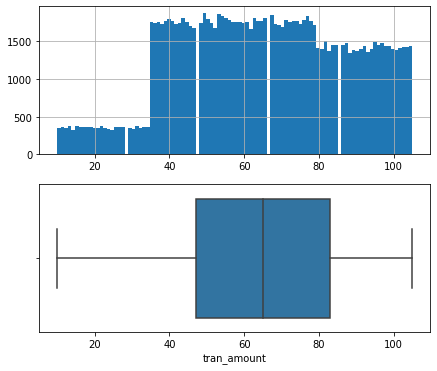

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(7,6))
df_transactions['tran_amount'].hist(bins=100, ax=axes[0])
sns.boxplot(data=df_transactions, x='tran_amount', ax=axes[1]);

## Time series

In [ ]:
df_transactions['trans_date'].min(), df_transactions['trans_date'].max()

(Timestamp('2011-05-16 00:00:00'), Timestamp('2015-03-16 00:00:00'))

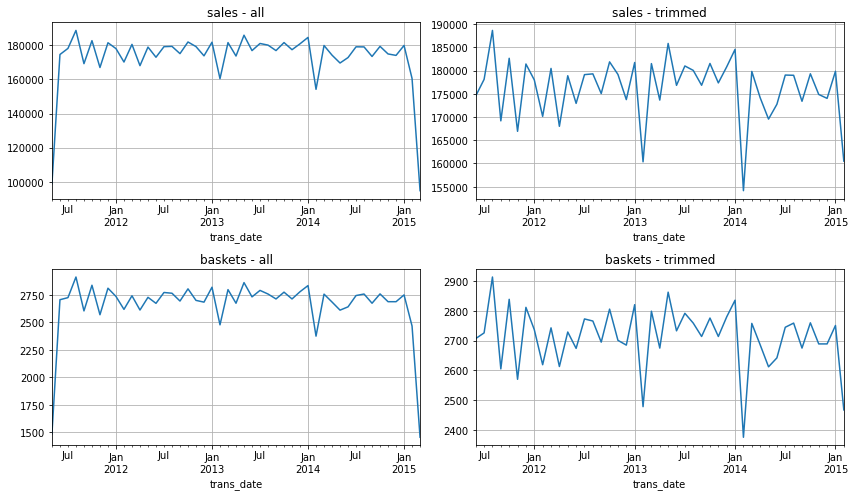

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12,7), tight_layout=True)
axes = axes.ravel()

df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].sum().plot(title='sales - all', ax=axes[0])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].sum().iloc[1:-1].plot(title='sales - trimmed', ax=axes[1])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].size().plot(title='baskets - all', ax=axes[2])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].size().iloc[1:-1].plot(title='baskets - trimmed', ax=axes[3])
for ax in axes:
    ax.grid(True)

plt.show()

The latest join date is on 2013-10-26 and the last transaction date is 2015-03-16. There seems to be a big gap of not acquiring new customers which makes me think that this given dataset might not be whole.

In [ ]:
df_transactions.groupby('customer_id')['trans_date'].min().sort_values().describe()

count                    6889
unique                    412
top       2011-05-24 00:00:00
freq                       99
first     2011-05-16 00:00:00
last      2013-10-26 00:00:00
Name: trans_date, dtype: object

## Cohort Analysis

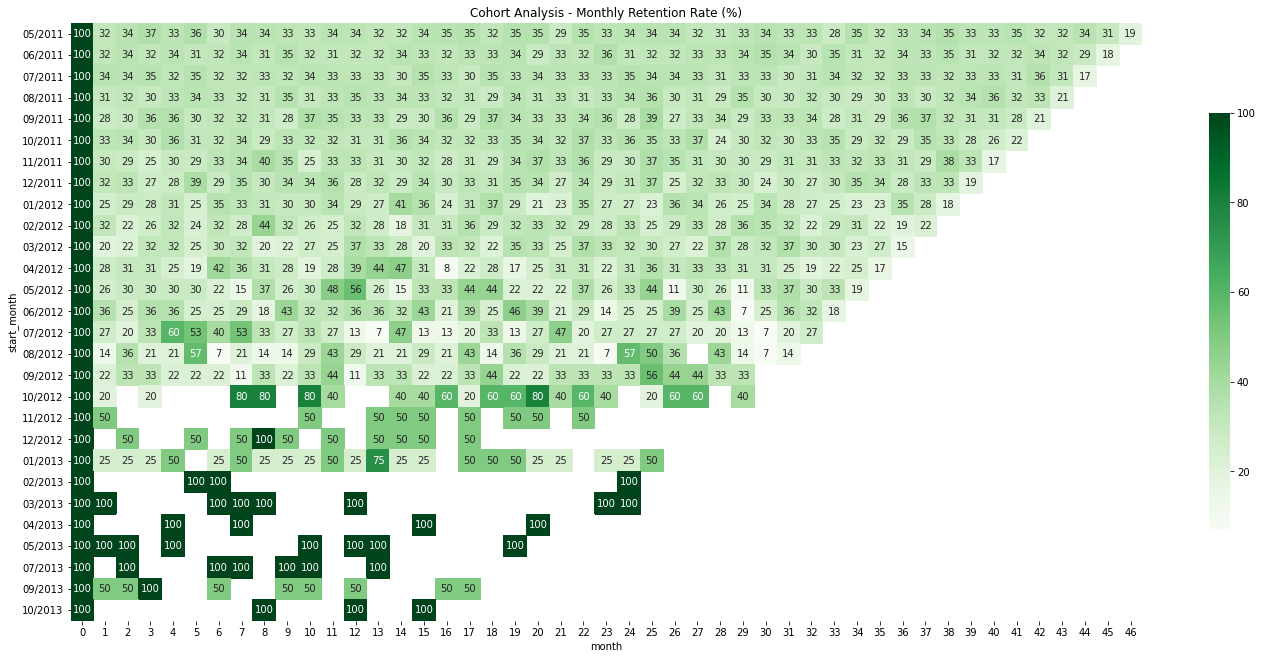

In [ ]:
cohort = df_transactions.groupby(['customer_id', pd.Grouper(key='trans_date',freq='M')]).size().reset_index()
cohort['start_month'] = cohort['customer_id'].map(cohort.groupby('customer_id')['trans_date'].min())
cohort['month'] = cohort.apply(lambda x: (x['trans_date'].year - x['start_month'].year)*12 + (x['trans_date'].month - x['start_month'].month) , axis=1)
cohort = pd.pivot_table(cohort, index='start_month', columns='month', values='customer_id', aggfunc='count').sort_index()
cohort = cohort.divide(cohort.iloc[:,0], axis=0).multiply(100)
cohort.index = cohort.index.strftime('%m/%Y')
plt.figure(figsize=(24,11))
sns.heatmap(cohort, cmap='Greens', annot=True, fmt='.0f', cbar_kws={'shrink':.7})
# plt.yticks(cohort.index.strftime('%m/%Y'))
plt.title('Cohort Analysis - Monthly Retention Rate (%)');

# Data Prep

In [ ]:
campaign_date = dt.datetime(2015,3,17)

df_transactions['age'] = (campaign_date - df_transactions['trans_date']).dt.days
df_transactions['weekend'] = df_transactions['trans_date'].dt.weekday.isin([5,6])

basket_cuts = [0,35,80,float('inf')]
df_transactions['basket_size'] = pd.cut(df_transactions['tran_amount'], basket_cuts, right=False, labels=['S','M','L'])

df_transactions = df_transactions.sort_values(['customer_id','trans_date'])
df_transactions.head()

,customer_id,trans_date,tran_amount,age,weekend,basket_size
77247,CS1112,2011-06-15,56,1371,False,M
89149,CS1112,2011-08-19,96,1306,False,L
68206,CS1112,2011-10-02,60,1262,True,M
36486,CS1112,2012-04-08,56,1073,True,M
93074,CS1112,2012-06-24,52,996,True,M


## Feature Engineering

In [ ]:
df = df_transactions.groupby('customer_id').agg(
        recency=('age', min),                       
        frequency=('customer_id', len),                  
        monetary=('tran_amount', sum), 
        tenure=('age', max),
        length_of_stay=('age', lambda x: x.max() - x.min()),
     )
# basket size stats
basket_size_df = df_transactions.groupby(['customer_id','basket_size'])['tran_amount'].agg(['size','sum']).unstack()
basket_size_df.columns = ['visit_basket_s','visit_basket_m','visit_basket_l','spend_basket_s','spend_basket_m','spend_basket_l']
df = df.join(basket_size_df)

df = df.join(df_transactions.groupby('customer_id').agg(
    ticket_size=('tran_amount','mean'),
    std_ticket_size=('tran_amount','std'),
    med_ticket_size=('tran_amount','median'),
    mad_ticket_size=('tran_amount','mad'),
    
))

event_df = df_transactions.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
event_df['num_repeat_sameday'] = event_df['num_trans'] - 1
event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days

df = df.join(event_df.groupby('customer_id').agg(avg_duration=('duration','mean'),std_duration=('duration','std'),
                                                # med_duration=('duration','median'), mad_duration=('duration','mad'),
                                                num_repeat_periods=('trans_date', lambda x: x.count() - 1),
                                                num_repeat_sameday=('num_repeat_sameday','sum')))

# df['recency_score'] = (df['recency'] - df['avg_duration'])/df['std_duration']
df['recency_score'] = np.log(df['recency'] / df['avg_duration'])

periods = [6, 12, 18, 24]
for n in periods:
    window_df = df_transactions[df_transactions.trans_date > df_transactions.trans_date.max() - relativedelta(months=n)]

    df = df.join(window_df.groupby('customer_id')['tran_amount'].agg(
        [ (f'monetary_{n}m','sum'), (f'frequency_{n}m', 'size'), 
        (f'avg_spend_{n}m', 'mean'), (f'std_spend_{n}m', 'std'),
         (f'iqr_spend_{n}m', lambda x: x.quantile(0.75) - x.quantile(0.25))]
    ))

    event_df = window_df.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
    event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
    event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days
    df = df.join(event_df.groupby('customer_id')['duration'].agg(
        [ (f'avg_dur_{n}m', 'mean'), (f'std_dur_{n}m', 'std'), 
         (f'iqr_dur_{n}m', lambda x: x.quantile(.75) - x.quantile(.25)),
         (f'num_repeat_{n}m', 'count')
         ]
    ))

df['velocity_monetary_6_12'] = df['avg_spend_6m'] / (df['monetary_12m']/12)
df['velocity_monetary_6_18'] = df['avg_spend_6m'] / (df['monetary_18m']/18)
df['velocity_monetary_6_24'] = df['avg_spend_6m'] / (df['monetary_24m']/24)
df['velocity_monetary_12_18'] = df['avg_spend_12m'] / (df['monetary_18m']/18)
df['velocity_monetary_12_24'] = df['avg_spend_12m'] / (df['monetary_24m']/24)


df.fillna(0, inplace=True)
df = df_response.set_index('customer_id').join(df)
df

,response,recency,frequency,monetary,tenure,length_of_stay,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,recency_score,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_18,velocity_monetary_12_24
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1371,1309,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,-0.410827,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.00,112.400000,51.456778,63.00,5.0,2.342629,2.739130,3.284916,3.507764,4.206704
CS1113,0,36,20,1490,1390,1354,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,-0.736928,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.00,73.333333,58.030165,76.00,9.0,2.239186,2.959641,2.270968,2.643498,2.028387
CS1114,1,33,19,1432,1342,1309,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,-0.790139,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.50,62.600000,64.740851,82.00,10.0,2.679365,1.941718,2.099502,1.739264,1.880597
CS1115,1,12,22,1659,1315,1303,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,-1.642995,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.50,71.500000,71.019950,47.75,10.0,2.661290,1.677966,1.588448,2.522034,2.387485
CS1116,1,204,13,857,1359,1155,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.751171,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,0.000000,0.000000,0.000000,3.864865,5.153153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CS8996,0,98,13,582,1218,1120,5,8,0,150.0,432.0,0.0,44.769231,18.749017,38.0,14.911243,93.333333,100.650912,12,0,0.048790,293.0,5.0,58.600000,23.479779,42.0,6.5,3.872983,4.5,4.0,336.0,6.0,56.000000,21.945387,37.75,23.600000,38.383590,6.00,5.0,369.0,7.0,52.714286,21.838149,38.50,62.833333,102.049824,66.00,6.0,369.0,7.0,52.714286,21.838149,38.50,62.833333,102.049824,66.00,6.0,2.092857,2.858537,3.811382,2.731707,3.642276
CS8997,0,262,14,543,1378,1116,5,9,0,127.0,416.0,0.0,38.785714,14.000981,38.5,9.785714,85.846154,77.791223,13,0,1.115788,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,45.0,1.0,45.000000,0.000000,0.00,0.000000,0.000000,0.00,0.0,223.0,5.0,44.600000,19.191144,6.

## Big spender

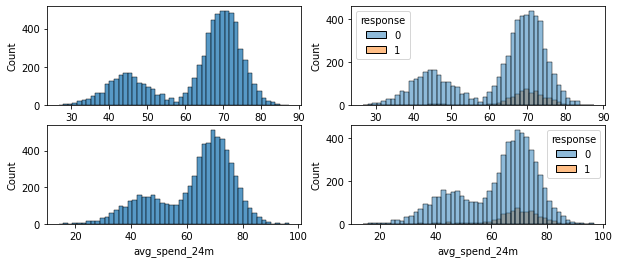

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10,4))
axes = axes.ravel()
sns.histplot(data=df, x='ticket_size',bins=50, ax=axes[0])
sns.histplot(data=df, x='ticket_size',bins=50, hue='response', ax=axes[1])
sns.histplot(data=df, x='avg_spend_24m',bins=50, ax=axes[2])
sns.histplot(data=df, x='avg_spend_24m',bins=50, hue='response', ax=axes[3])
plt.show();

In [ ]:
from sklearn.mixture import GaussianMixture

random_state = 18
# data = df[['ticket_size']].copy() # not using LTD, maybe
data = df[['avg_spend_24m']].copy()
gm = GaussianMixture(n_components=2, random_state=random_state).fit(data)
labels = gm.predict(data)
prob = gm.predict_proba(data)
data['is_big_spender'] = (labels == 0).astype('int')
data['prob_big_spender'] = np.round(prob[:,0],6)
data['response'] = df['response']
print(gm.means_)

[[70.25380743]
 [44.52875213]]


In [ ]:
# temp = data.groupby('is_big_spender').agg(count=('ticket_size','size'), response=('response','sum'))
temp = data.groupby('is_big_spender').agg(count=('avg_spend_24m','size'), response=('response','sum'))
temp['% response'] = temp['response'] / temp['count']
temp

,count,response,% response
is_big_spender,,,
0,1840,46,0.025000
1,5044,601,0.119151


In [ ]:
df = df.join(data[['is_big_spender','prob_big_spender']])
df.head()

,response,recency,frequency,monetary,tenure,length_of_stay,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,recency_score,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_18,velocity_monetary_12_24,is_big_spender,prob_big_spender
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1371,1309,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,-0.410827,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.0,112.400000,51.456778,63.00,5.0,2.342629,2.739130,3.284916,3.507764,4.206704,1,0.824019
CS1113,0,36,20,1490,1390,1354,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,-0.736928,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.0,73.333333,58.030165,76.00,9.0,2.239186,2.959641,2.270968,2.643498,2.028387,1,0.997034
CS1114,1,33,19,1432,1342,1309,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,-0.790139,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.5,62.600000,64.740851,82.00,10.0,2.679365,1.941718,2.099502,1.739264,1.880597,1,0.998790
CS1115,1,12,22,1659,1315,1303,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,-1.642995,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.5,71.500000,71.019950,47.75,10.0,2.661290,1.677966,1.588448,2.522034,2.387485,1,0.999448
CS1116,1,204,13,857,1359,1155,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.751171,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.0,49.750000,31.245000,38.25,4.0,0.000000,0.000000,0.000000,3.864865,5.153153,1,0.987881


## BTYD (Experiment)

just trying

In [ ]:
# prep BTYD data by the definition of it
data = df[['num_repeat_periods','length_of_stay','tenure','ticket_size']].rename({'num_repeat_periods':'frequency', 'length_of_stay':'recency', 'tenure':'T', 'ticket_size':'monetary_value'}, axis=1).copy()
# data = df[['num_repeat_24m','length_of_stay','tenure','avg_spend_24m']].rename({'num_repeat_24m':'frequency', 'length_of_stay':'recency', 'tenure':'T', 'avg_spend_24m':'monetary_value'}, axis=1).copy()
# data['recency'] = data.apply(lambda x: x['recency'] if x['frequency'] > 0 else 0, axis=1)
data.head(5)

,frequency,recency,T,monetary_value
customer_id,,,,
CS1112,14,1309,1371,67.466667
CS1113,18,1354,1390,74.500000
CS1114,18,1309,1342,75.368421
CS1115,21,1303,1315,75.409091
CS1116,12,1155,1359,65.923077


In [ ]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=.05)
bgf.fit(data['frequency'], data['recency'], data['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.018553e+00,2.479525e-02,1.969954e+00,2.067151e+00
alpha,1.568181e+02,2.383701e+00,1.521460e+02,1.614902e+02
a,2.602381e-19,1.296708e-13,-2.541544e-13,2.541550e-13
b,5.514482e-08,2.747572e-02,-5.385236e-02,5.385247e-02


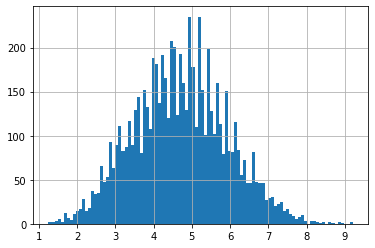

In [ ]:
df['expected_num_trans_1y'] = bgf.conditional_expected_number_of_purchases_up_to_time(365, data['frequency'], data['recency'], data['T'])
df['expected_num_trans_1y'].hist(bins=100);

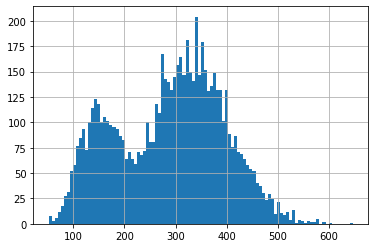

In [ ]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.05)
ggf.fit(data['frequency'], data['monetary_value'])

df['clv_1y'] = ggf.customer_lifetime_value(bgf, data['frequency'], data['recency'], data['T'], data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)
df['clv_1y'].hist(bins=100);

## Save file

In [ ]:
df.to_csv('prep_customers.csv')

# Feature EDA

In [ ]:
df = pd.read_csv('prep_customers.csv', index_col=0)
print(df.shape)
df.head()

(6884, 66)


,response,recency,frequency,monetary,tenure,length_of_stay,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,recency_score,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_18,velocity_monetary_12_24,is_big_spender,prob_big_spender,expected_num_trans_1y,clv_1y
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1371,1309,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,-0.410827,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.0,112.400000,51.456778,63.00,5.0,2.342629,2.739130,3.284916,3.507764,4.206704,1,0.824019,3.826877,246.084778
CS1113,0,36,20,1490,1390,1354,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,-0.736928,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.0,73.333333,58.030165,76.00,9.0,2.239186,2.959641,2.270968,2.643498,2.028387,1,0.997034,4.723743,333.137567
CS1114,1,33,19,1432,1342,1309,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,-0.790139,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.5,62.600000,64.740851,82.00,10.0,2.679365,1.941718,2.099502,1.739264,1.880597,1,0.998790,4.875022,347.808945
CS1115,1,12,22,1659,1315,1303,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,-1.642995,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.5,71.500000,71.019950,47.75,10.0,2.661290,1.677966,1.588448,2.522034,2.387485,1,0.999448,5.708431,406.138371
CS1116,1,204,13,857,1359,1155,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.751171,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.0,49.750000,31.245000,38.25,4.0,0.000000,0.000000,0.000000,3.864865,5.153153,1,0.987881,3.375584,213.184011


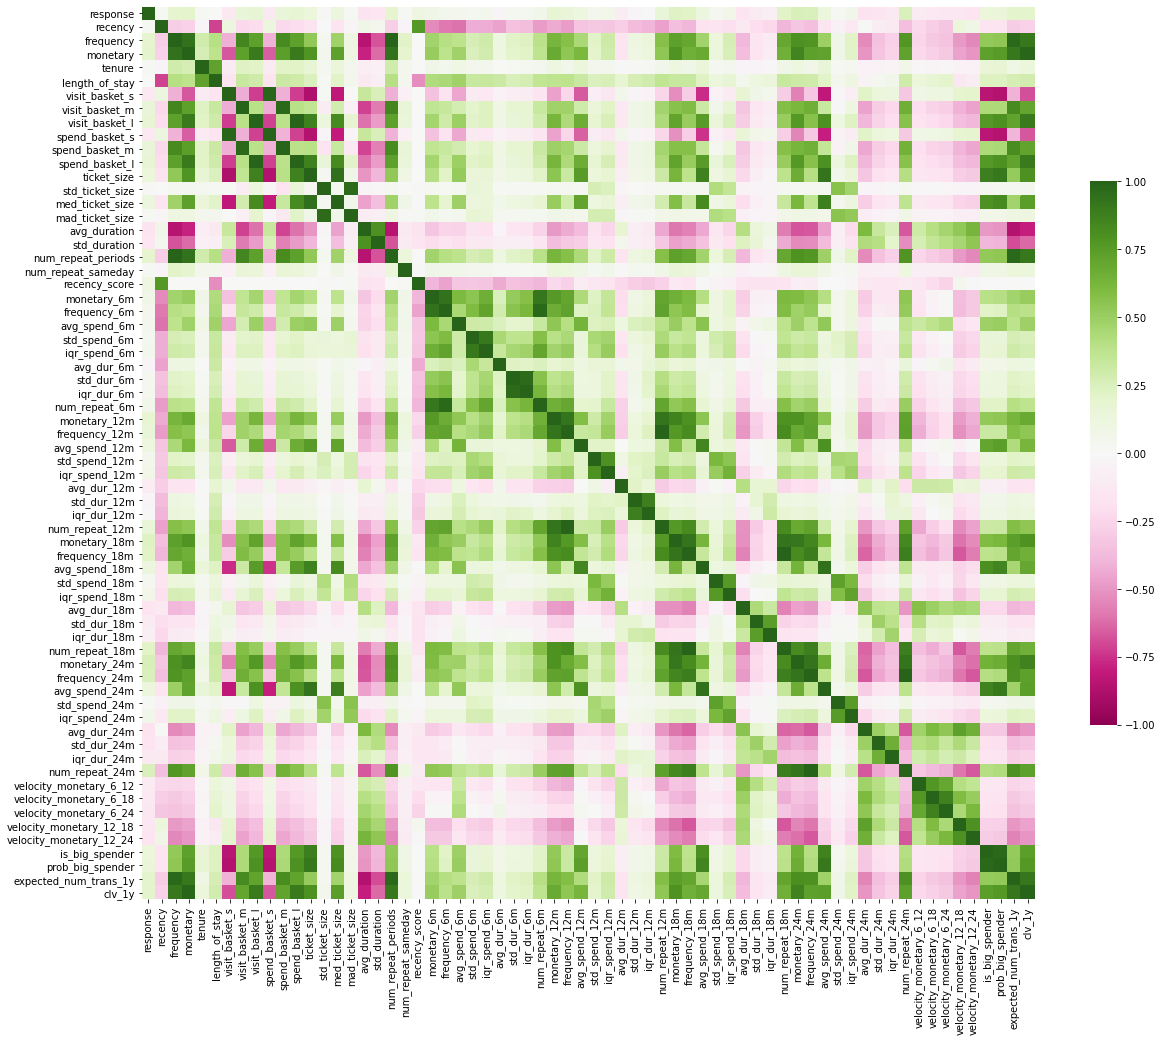

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap='PiYG', vmin=-1, vmax=1, annot=False, fmt='.1f', square=True, cbar_kws = {'shrink':.5});

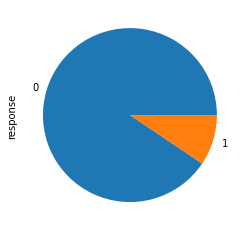

In [ ]:
df['response'].value_counts().plot.pie();

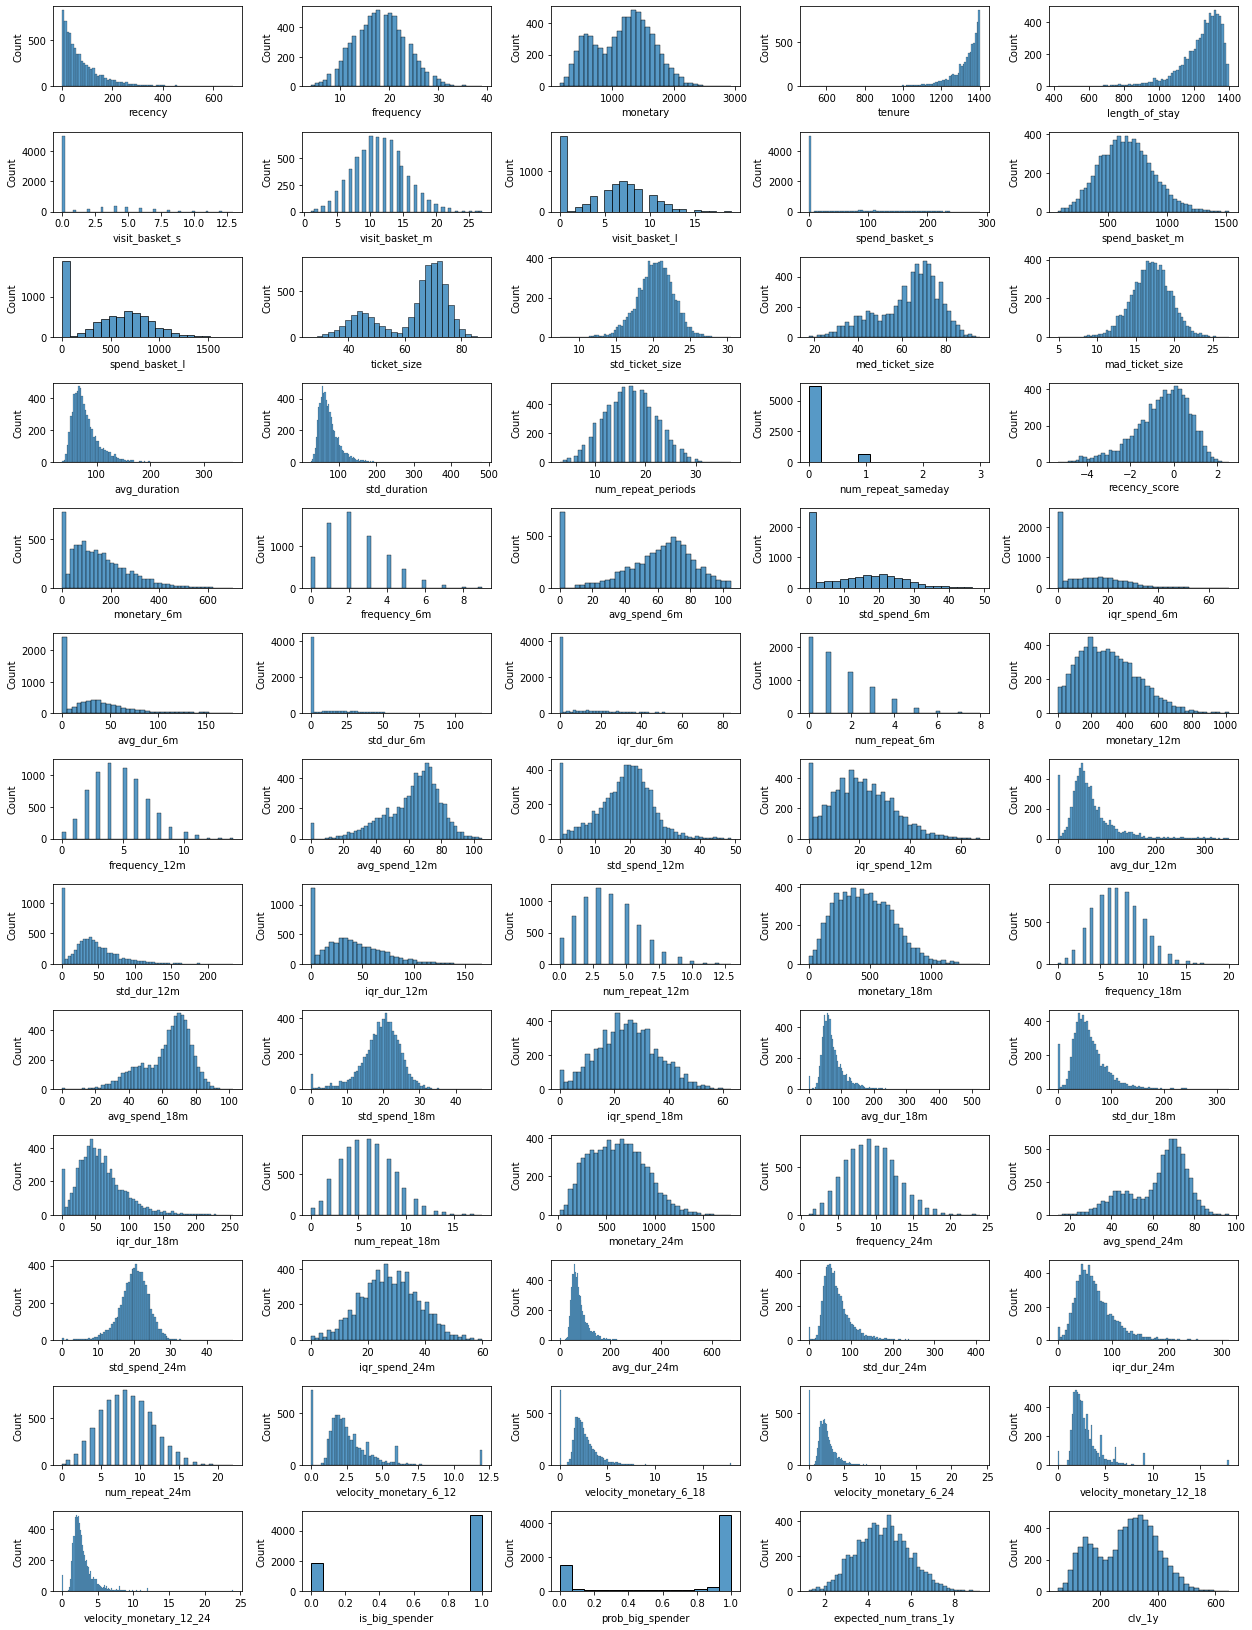

In [ ]:
n_cols = 5
n_rows, mod = divmod(len(df.columns[1:]), n_cols)
n_rows +=  int(mod > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(df.columns[1:], axes):
    sns.histplot(df[col], ax=ax)
plt.show()

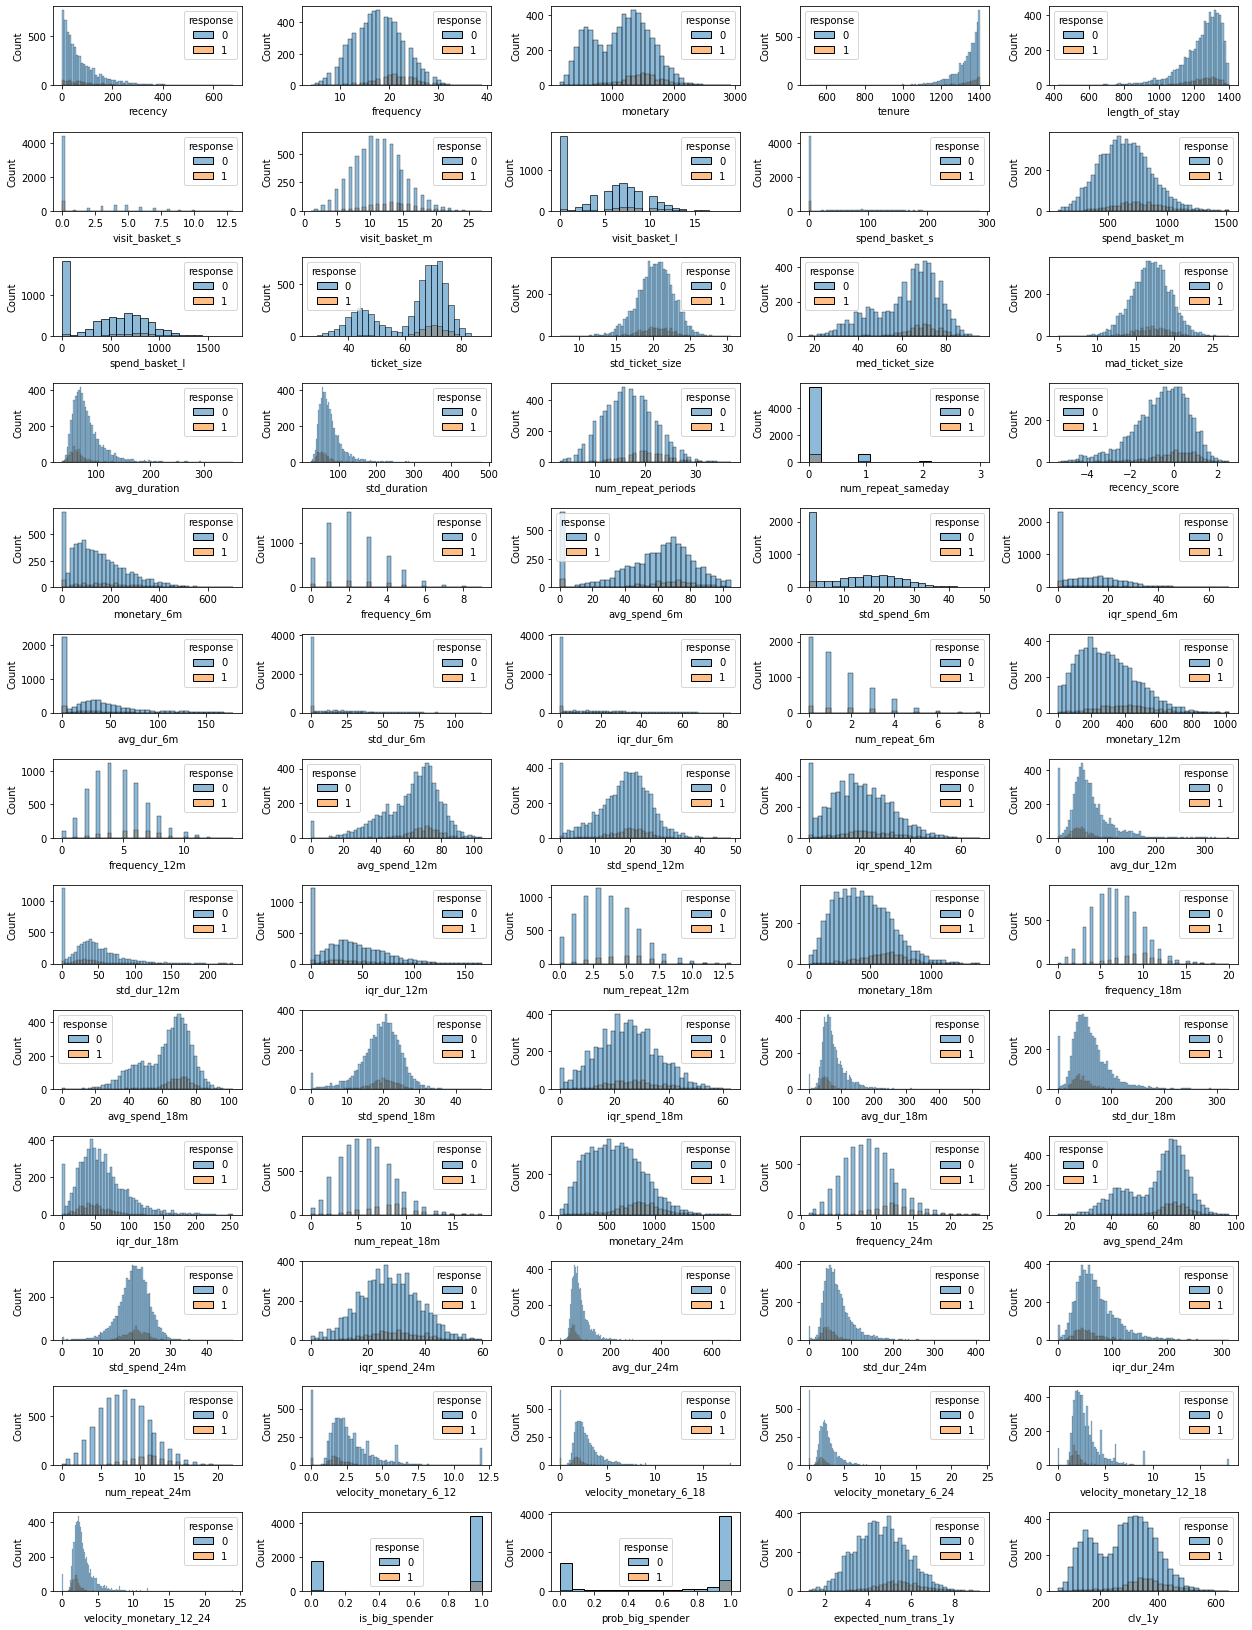

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(df.columns[1:], axes):
    sns.histplot(df, x=col, hue='response', ax=ax)
plt.show()

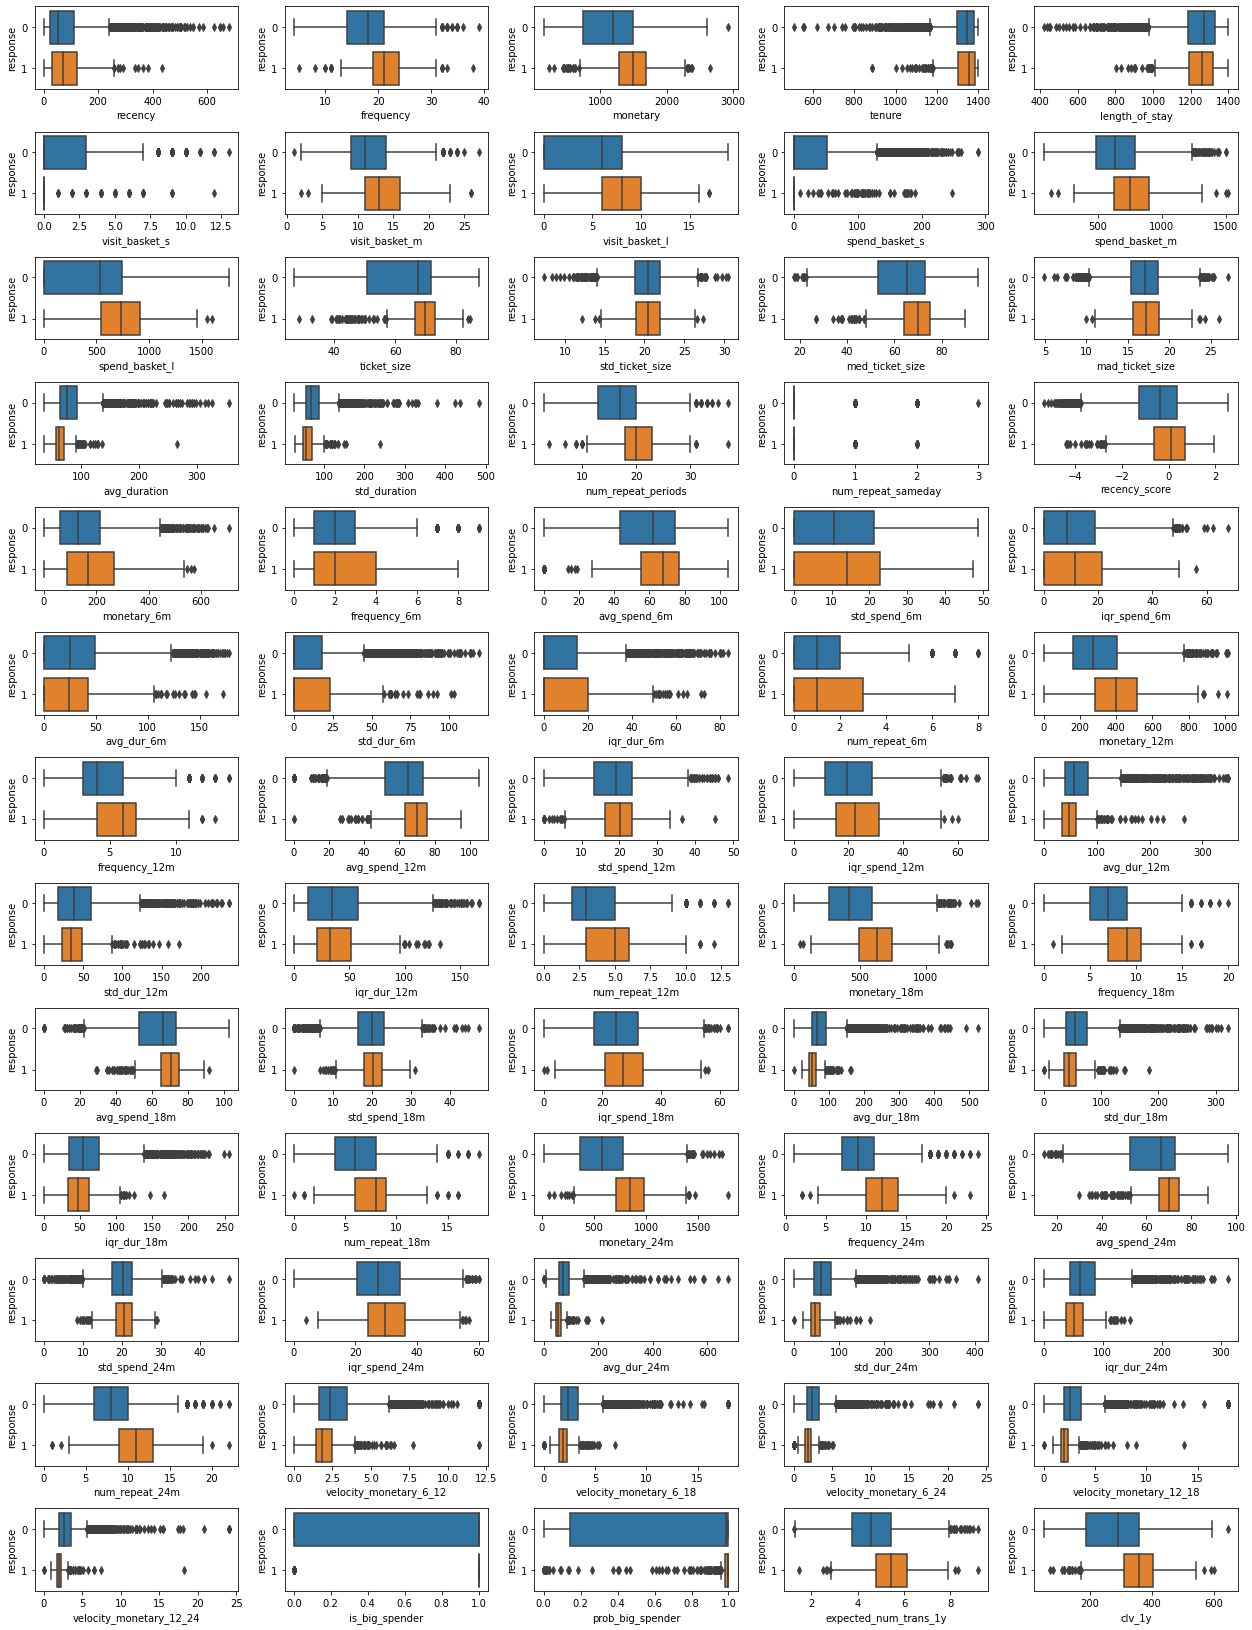

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(df.columns[1:], axes):
    sns.boxplot(data=df, y='response', x=col, ax=ax, orient='h')
plt.show()

[0.357359   0.10073521]


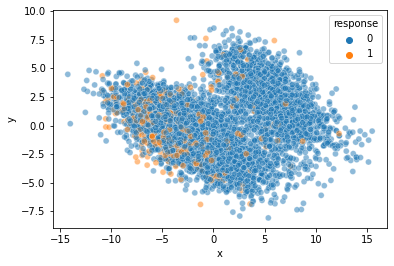

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X = df.drop(['response'],axis=1)
X_std = scale(X)

pca = PCA(2)
embed = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)
sns.scatterplot(data=pd.DataFrame({'x':embed[:,0],'y':embed[:,1],'response':df['response']}), x='x', y='y', hue='response', alpha=.5);

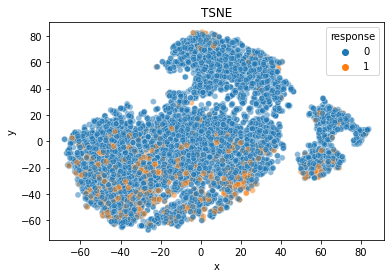

In [ ]:
from sklearn.manifold import TSNE
embed_tsne = TSNE(2).fit_transform(X_std)
sns.scatterplot(data=pd.DataFrame({'x':embed_tsne[:,0],'y':embed_tsne[:,1],'response':df['response']}), x='x', y='y', hue='response', alpha=.5)
plt.title('TSNE');

## Experiment with Trees

In [ ]:
random_state = 18

X = df.drop('response', axis=1)
y = df['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 65)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 65)
Number transactions y_test dataset:  (2066,)


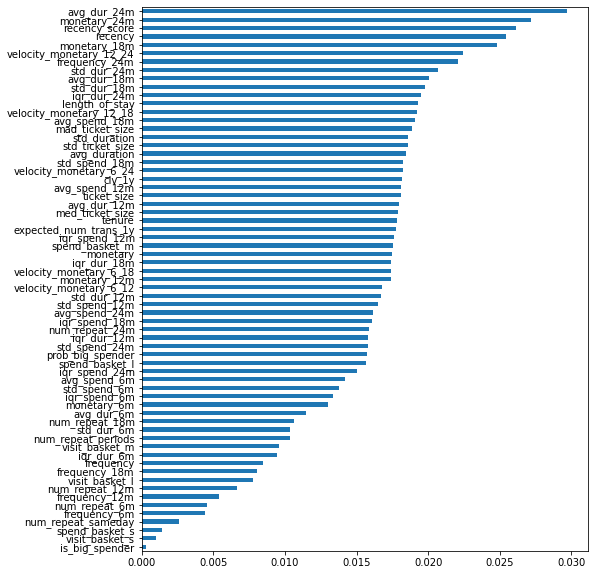

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=random_state).fit(X, y)
y_pred = clf.predict(X)
ft_imp1 = pd.Series(clf.feature_importances_, index=X.columns).sort_values()
ft_imp1.plot.barh(figsize=(8,10));

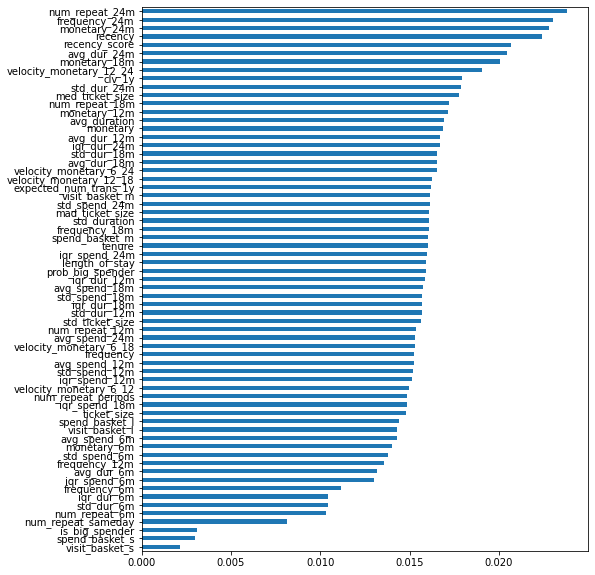

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(random_state=random_state).fit(X,y)
ft_imp2 = pd.Series(clf.feature_importances_, index=X.columns).sort_values()
ft_imp2.plot.barh(figsize=(8,10));

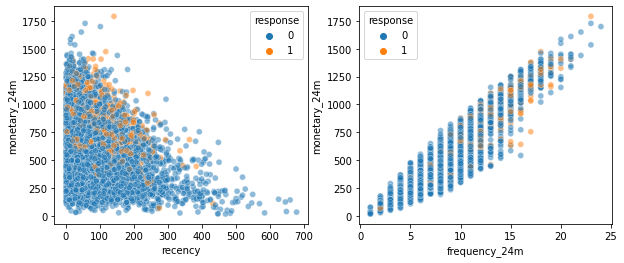

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=df, x='recency', y='monetary_24m', hue='response', alpha=.5, ax=axes[0])
sns.scatterplot(data=df, x='frequency_24m', y='monetary_24m', hue='response', alpha=.5, ax=axes[1])
# sns.scatterplot(data=df, x='avg_dur_24m', y='velocity_monetary_12_24', hue='response', alpha=.5, ax=axes[2])
plt.show()

# Creating train and test sets

In [ ]:
"""
fieldset1 = ['recency', 'tenure', 'length_of_stay', 'monetary_6m', 'frequency_6m',
    'avg_spend_6m', 'std_spend_6m', 'iqr_spend_6m', 'avg_dur_6m',
    'std_dur_6m', 'iqr_dur_6m', 'monetary_12m', 'frequency_12m',
    'avg_spend_12m', 'std_spend_12m', 'iqr_spend_12m', 'avg_dur_12m',
    'std_dur_12m', 'iqr_dur_12m', 'monetary_18m', 'frequency_18m',
    'avg_spend_18m', 'std_spend_18m', 'iqr_spend_18m', 'avg_dur_18m',
    'std_dur_18m', 'iqr_dur_18m', 'monetary_24m', 'frequency_24m',
    'avg_spend_24m', 'std_spend_24m', 'iqr_spend_24m', 'avg_dur_24m',
    'std_dur_24m', 'iqr_dur_24m', 'velocity_monetary_6_12',
    'velocity_monetary_6_18', 'velocity_monetary_6_24',
    'velocity_monetary_12_18', 'velocity_monetary_12_24',
    'prob_big_spender']
"""

In [ ]:
random_state = 18
test_size = 0.3

# exclude_fields = []
exclude_fields = [
                'spend_basket_s','visit_basket_s','spend_basket_m','visit_basket_m','spend_basket_l','visit_basket_l','num_repeat_sameday', 'is_big_spender',# trivial
                'monetary','frequency','ticket_size','std_ticket_size','mad_ticket_size','med_ticket_size', # drop LTD features
                'avg_duration','std_duration', 'num_repeat_periods', # drop LTD features
                # 'monetary_6m', 'frequency_6m','avg_spend_6m','std_spend_6m','iqr_spend_6m','avg_dur_6m','std_dur_6m','iqr_dur_6m', # drop 6m features
                # 'monetary_18m', 'frequency_18m','avg_spend_18m','std_spend_18m','iqr_spend_18m','avg_dur_18m','std_dur_18m','iqr_dur_18m', # drop 18m features
                'num_repeat_6m','num_repeat_12m','num_repeat_18m','num_repeat_24m',
                'clv_1y', 'expected_num_trans_1y','recency_score',
                ]

X = df.drop(['response'] + exclude_fields, axis=1).copy()
y = df['response']
cols = list(X.columns) + ['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 41)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 41)
Number transactions y_test dataset:  (2066,)


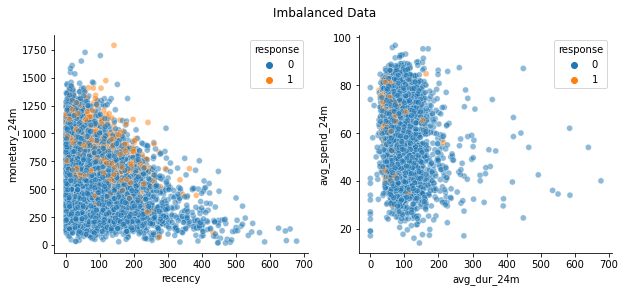

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=df, x='recency', y='monetary_24m', hue='response', alpha=.5, ax=axes[0])
sns.scatterplot(data=df, x='avg_dur_24m', y='avg_spend_24m', hue='response', alpha=.5, ax=axes[1])
sns.despine()
plt.suptitle("Imbalanced Data");

# Fixing imbalanced

## Undersampling

(860, 41) (860,) 0.5


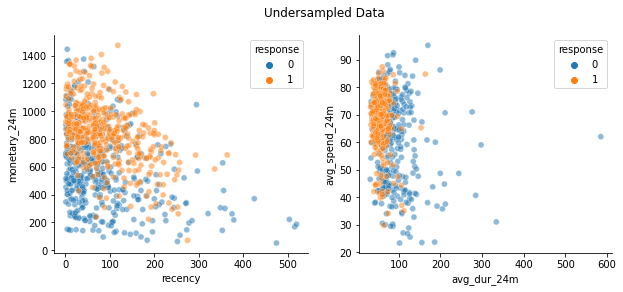

In [ ]:
rus = RandomUnderSampler(random_state=random_state)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
X_undersampled = pd.DataFrame(X_undersampled, columns=X_train.columns)
y_undersampled = pd.Series(y_undersampled, name='response')
print(X_undersampled.shape, y_undersampled.shape, y_undersampled.mean())

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=X_undersampled.join(y_undersampled), x='recency', y='monetary_24m', hue='response', alpha=.5, ax=axes[0])
sns.scatterplot(data=X_undersampled.join(y_undersampled), x='avg_dur_24m', y='avg_spend_24m', hue='response', alpha=.5, ax=axes[1])
sns.despine()
plt.suptitle("Undersampled Data");

## Oversampling

(8776, 41) (8776,) 0.5


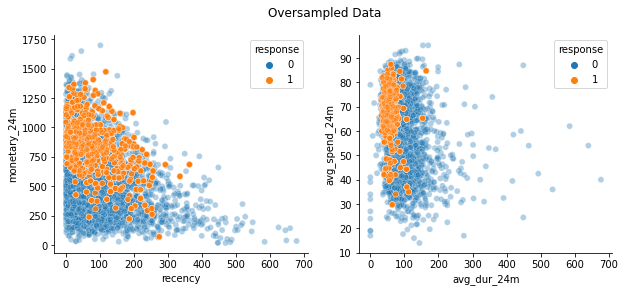

In [ ]:
ros = RandomOverSampler(random_state=random_state)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
X_oversampled = pd.DataFrame(X_oversampled, columns=X_train.columns)
y_oversampled = pd.Series(y_oversampled, name='response')
print(X_oversampled.shape, y_oversampled.shape, y_oversampled.mean())

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=X_oversampled.join(y_oversampled), x='recency', y='monetary_24m', hue='response', alpha=.35, ax=axes[0])
sns.scatterplot(data=X_oversampled.join(y_oversampled), x='avg_dur_24m', y='avg_spend_24m', hue='response', alpha=.35, ax=axes[1])
sns.despine()
plt.suptitle("Oversampled Data");

## SMOTE

(8776, 41) (8776,) 0.5


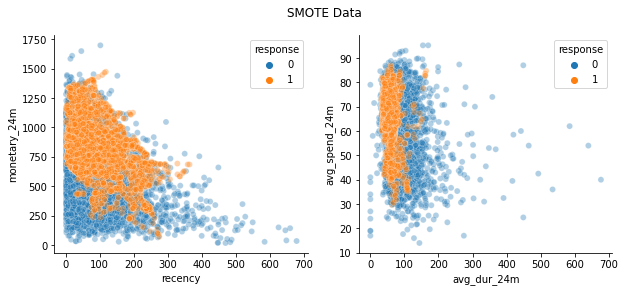

In [ ]:
sm = SMOTE(random_state=random_state)
sm.fit(X_train, y_train)
X_smote, y_smote = sm.fit_sample(X_train, y_train)
X_smote = pd.DataFrame(X_smote, columns=X_train.columns)
y_smote = pd.Series(y_smote, name='response')
print(X_smote.shape, y_smote.shape, y_smote.mean())

# sns.scatterplot(data=X_smote.join(y_smote), x='recency', y='monetary', hue='response', alpha=.5)
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=X_smote.join(y_smote), x='recency', y='monetary_24m', hue='response', alpha=.35, ax=axes[0])
sns.scatterplot(data=X_smote.join(y_smote), x='avg_dur_24m', y='avg_spend_24m', hue='response', alpha=.35, ax=axes[1])
sns.despine()
plt.suptitle("SMOTE Data");

## SMOTE + Tomek Links

(8762, 41) (8762,) 0.5


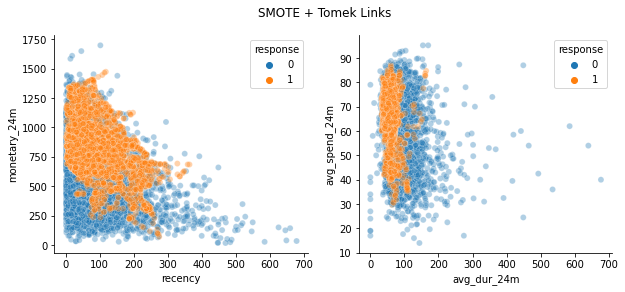

In [ ]:
smtomek = SMOTETomek(random_state=random_state)
X_smotetomek, y_smotetomek = smtomek.fit_sample(X_train, y_train)

X_smotetomek = pd.DataFrame(X_smotetomek, columns=X_train.columns)
y_smotetomek = pd.Series(y_smotetomek, name='response')
print(X_smotetomek.shape, y_smotetomek.shape, y_smotetomek.mean())

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=X_smotetomek.join(y_smotetomek), x='recency', y='monetary_24m', hue='response', alpha=.35, ax=axes[0])
sns.scatterplot(data=X_smotetomek.join(y_smotetomek), x='avg_dur_24m', y='avg_spend_24m', hue='response', alpha=.35, ax=axes[1])
sns.despine()
plt.suptitle("SMOTE + Tomek Links");

## SMOTE + ENN

(7145, 41) (7145,) 0.6060181945416375


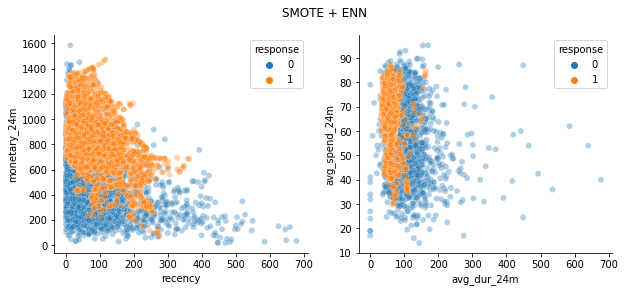

In [ ]:
smtenn = SMOTEENN(random_state=random_state)
X_smoteenn, y_smoteenn = smtenn.fit_sample(X_train, y_train)

X_smoteenn = pd.DataFrame(X_smoteenn, columns=X_train.columns)
y_smoteenn = pd.Series(y_smoteenn, name='response')
print(X_smoteenn.shape, y_smoteenn.shape, y_smoteenn.mean())

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=X_smoteenn.join(y_smoteenn), x='recency', y='monetary_24m', hue='response', alpha=.35, ax=axes[0])
sns.scatterplot(data=X_smoteenn.join(y_smoteenn), x='avg_dur_24m', y='avg_spend_24m', hue='response', alpha=.35, ax=axes[1])
sns.despine()
plt.suptitle("SMOTE + ENN");

# Modeling

In [ ]:
train_sets = {
    'imbalanced' : [X_train, y_train],
    'undersampled' : [X_undersampled, y_undersampled],
    'oversampled' : [X_oversampled, y_oversampled],
    'smote' : [X_smote, y_smote],
    'smote-enn' : [X_smoteenn, y_smoteenn],
    'smote-tomek' : [X_smotetomek, y_smotetomek]
}

## Logistic Regression

In [ ]:
def init_logreg():
    return LogisticRegression(solver='liblinear', class_weight='balanced', random_state=random_state)

def train_logreg(model, data, targets):
    model.fit(data, targets)
    y_pred_train = model.predict(data)
    report_train = classification_report(targets, y_pred_train, output_dict=False)
    print('Training set')
    print(report_train)

    y_pred_test = model.predict(X_test)
    report_test = classification_report(y_test, y_pred_test, output_dict=False)
    print('Test set')
    print(report_test)
    return model

def plot_logreg_roc_curve(model, data, targets, name):
    y_score_train = model.decision_function(data)
    fpr_train, tpr_train, _ = roc_curve(targets,  y_score_train)
    auc_train = roc_auc_score(targets, y_score_train)
    plt.plot(fpr_train,tpr_train, color='tomato', label=f'Train - AUC={round(auc_train,4)}')

    y_score_test = model.decision_function(X_test)
    fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
    auc_test = roc_auc_score(y_test, y_score_test)
    plt.plot(fpr_test,tpr_test, color='dodgerblue', label=f' Test - AUC={round(auc_test,4)}')

    plt.plot([0, 1], [0, 1], color='.7', lw=2, linestyle='--')
    plt.title(f"{type(model).__name__} - {name}")
    plt.legend(loc=4)
    plt.show()

### Imbalanced

Training set
              precision    recall  f1-score   support

           0       0.97      0.67      0.79      4388
           1       0.19      0.80      0.31       430

    accuracy                           0.68      4818
   macro avg       0.58      0.73      0.55      4818
weighted avg       0.90      0.68      0.75      4818

Test set
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1849
           1       0.21      0.74      0.33       217

    accuracy                           0.68      2066
   macro avg       0.58      0.71      0.56      2066
weighted avg       0.88      0.68      0.74      2066



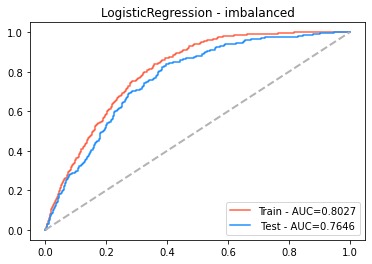

In [ ]:
name = 'imbalanced'
data, targets = train_sets[name]

model = init_logreg()
model = train_logreg(model, data, targets)
plot_logreg_roc_curve(model, data, targets, name)

### Undersampled

Training set
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       430
           1       0.73      0.80      0.76       430

    accuracy                           0.75       860
   macro avg       0.75      0.75      0.75       860
weighted avg       0.75      0.75      0.75       860

Test set
              precision    recall  f1-score   support

           0       0.95      0.67      0.78      1849
           1       0.20      0.71      0.31       217

    accuracy                           0.67      2066
   macro avg       0.58      0.69      0.55      2066
weighted avg       0.87      0.67      0.73      2066



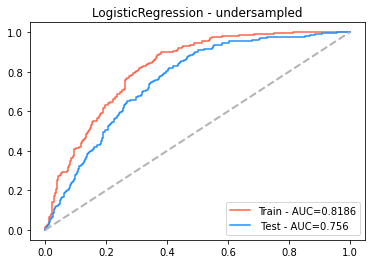

In [ ]:
name = 'undersampled'
data, targets = train_sets[name]

model = init_logreg()
model = train_logreg(model, data, targets)
plot_logreg_roc_curve(model, data, targets, name)

### Oversampled

Training set
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      4388
           1       0.71      0.81      0.75      4388

    accuracy                           0.74      8776
   macro avg       0.74      0.74      0.74      8776
weighted avg       0.74      0.74      0.74      8776

Test set
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1849
           1       0.21      0.73      0.32       217

    accuracy                           0.68      2066
   macro avg       0.58      0.70      0.56      2066
weighted avg       0.88      0.68      0.74      2066



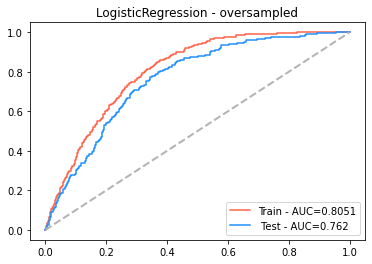

In [ ]:
name = 'oversampled'
data, targets = train_sets[name]

model = init_logreg()
model = train_logreg(model, data, targets)
plot_logreg_roc_curve(model, data, targets, name)

### SMOTE

Training set
              precision    recall  f1-score   support

           0       0.79      0.67      0.72      4388
           1       0.71      0.82      0.76      4388

    accuracy                           0.75      8776
   macro avg       0.75      0.75      0.74      8776
weighted avg       0.75      0.75      0.74      8776

Test set
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1849
           1       0.21      0.71      0.32       217

    accuracy                           0.68      2066
   macro avg       0.58      0.70      0.56      2066
weighted avg       0.87      0.68      0.74      2066



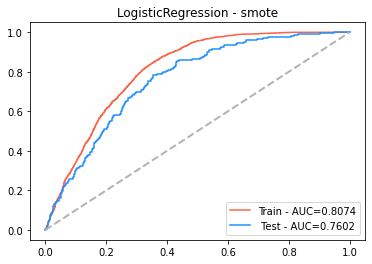

In [ ]:
name = 'smote'
data, targets = train_sets[name]

model = init_logreg()
model = train_logreg(model, data, targets)
plot_logreg_roc_curve(model, data, targets, name)

### SMOTE-ENN

Training set
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      2815
           1       0.88      0.87      0.87      4330

    accuracy                           0.84      7145
   macro avg       0.84      0.84      0.84      7145
weighted avg       0.85      0.84      0.85      7145

Test set
              precision    recall  f1-score   support

           0       0.96      0.62      0.75      1849
           1       0.20      0.79      0.31       217

    accuracy                           0.64      2066
   macro avg       0.58      0.70      0.53      2066
weighted avg       0.88      0.64      0.71      2066



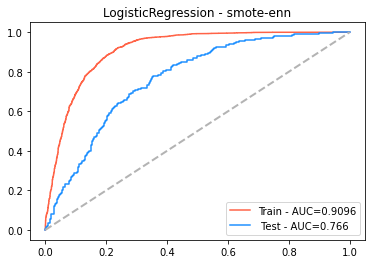

In [ ]:
name = 'smote-enn'
data, targets = train_sets[name]

model = init_logreg()
model = train_logreg(model, data, targets)
plot_logreg_roc_curve(model, data, targets, name)

### SMOTE-TOMEK

Training set
              precision    recall  f1-score   support

           0       0.79      0.67      0.73      4381
           1       0.71      0.82      0.76      4381

    accuracy                           0.75      8762
   macro avg       0.75      0.75      0.75      8762
weighted avg       0.75      0.75      0.75      8762

Test set
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1849
           1       0.21      0.71      0.32       217

    accuracy                           0.68      2066
   macro avg       0.58      0.70      0.56      2066
weighted avg       0.87      0.68      0.74      2066



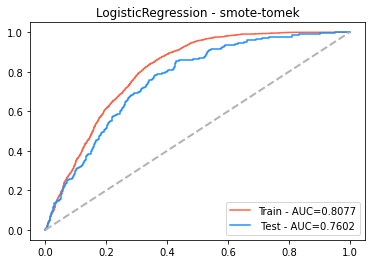

In [ ]:
name = 'smote-tomek'
data, targets = train_sets[name]

model = init_logreg()
model = train_logreg(model, data, targets)
plot_logreg_roc_curve(model, data, targets, name)

## LightGBM

[1]	valid_0's auc: 0.761133
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.75908
[3]	valid_0's auc: 0.768452
[4]	valid_0's auc: 0.771602
[5]	valid_0's auc: 0.771381
[6]	valid_0's auc: 0.774275
[7]	valid_0's auc: 0.774564
[8]	valid_0's auc: 0.775703
[9]	valid_0's auc: 0.775298
[10]	valid_0's auc: 0.776265
[11]	valid_0's auc: 0.775294
[12]	valid_0's auc: 0.775954
[13]	valid_0's auc: 0.775906
[14]	valid_0's auc: 0.775233
[15]	valid_0's auc: 0.774373
[16]	valid_0's auc: 0.7736
[17]	valid_0's auc: 0.773999
[18]	valid_0's auc: 0.77419
[19]	valid_0's auc: 0.771984
[20]	valid_0's auc: 0.770959
[21]	valid_0's auc: 0.772357
[22]	valid_0's auc: 0.773017
[23]	valid_0's auc: 0.772554
[24]	valid_0's auc: 0.775148
[25]	valid_0's auc: 0.774734
[26]	valid_0's auc: 0.778578
[27]	valid_0's auc: 0.779734
[28]	valid_0's auc: 0.780305
[29]	valid_0's auc: 0.782066
[30]	valid_0's auc: 0.782881
[31]	valid_0's auc: 0.781233
[32]	valid_0's auc: 0.781398
[33]	valid_0's auc: 0.

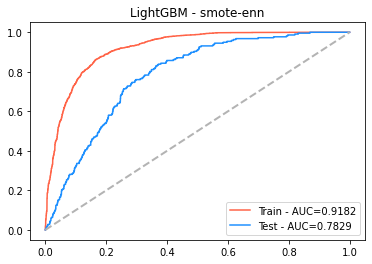

In [ ]:
name = 'smote-enn'
data, targets = train_sets[name]

train_data = lgb.Dataset(data, label=targets)
test_data = lgb.Dataset(X_test, label=y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt', 
    # 'boosting' : 'dart',
    'num_leaves': 30,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.03,
    'bagging_freq': 20,
    'learning_rate': 0.055,
    # 'n_estimators' : 500,
    # 'reg_alpha' : 21,
    # 'reg_lambda' : 12,
    # 'colsample_bytree' : 0.65,
    'verbose': 0,
    # 'subsample_for_bin': 200000,
    # 'subsample_freq' : 0,
}

model = lgb.train(parameters,train_data,valid_sets=test_data,num_boost_round=5000,early_stopping_rounds=100)

y_score_train = model.predict(data)
fpr_train, tpr_train, _ = roc_curve(targets,  y_score_train)
auc_train = roc_auc_score(targets, y_score_train)
plt.plot(fpr_train,tpr_train, color='tomato', label=f'Train - AUC={round(auc_train,4)}')

y_score_test = model.predict(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='dodgerblue', label=f'Test - AUC={round(auc_test,4)}')

plt.plot([0, 1], [0, 1], color='.7', lw=2, linestyle='--')
plt.title(f"LightGBM - {name}")
plt.legend(loc=4)
plt.show()

## XGBoost

In [ ]:
def init_xgboost_model():
    return xgb.XGBClassifier(objective ='binary:logistic', random_state=random_state,
                             colsample_bytree = 0.65,
                             learning_rate = 0.03,
                             max_depth = 3,
                             reg_alpha=21,
                             reg_lambda=12,
                             gamma=1,
                             n_estimators = 500,
                             eval_metric='auc')

def train_xgboost(model, data, targets):
    return model.fit(data, targets, early_stopping_rounds=50, eval_set=[(X_test, y_test)])

def plot_xgboost_roc_curve(model, data, targets):
    y_score_train = model.predict_proba(data)
    fpr_train, tpr_train, _ = roc_curve(targets,  y_score_train[:,1])
    auc_train = roc_auc_score(targets, y_score_train[:,1])
    plt.plot(fpr_train,tpr_train, color='tomato', label=f'Train - AUC={round(auc_train,4)}')

    y_score_test = model.predict_proba(X_test)
    fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
    auc_test = roc_auc_score(y_test, y_score_test[:,1])
    plt.plot(fpr_test,tpr_test, color='dodgerblue', label=f'Test - AUC={round(auc_test,4)}')

    plt.plot([0, 1], [0, 1], color='.7', lw=2, linestyle='--')
    plt.title(f"{type(model).__name__} - {name}")
    plt.legend(loc=4)
    plt.show()


def plot_pr_curve(model, X, y):
    baseline = sum(y == 1) / len(y)
    ax = plt.gca()
    plot_precision_recall_curve(model, X, y, ax=ax)
    ax.plot([0,1],[baseline, baseline], linestyle='--', label='baseline')
    ax.legend(loc='upper right')

### Imbalanced - Weighted XGBoost

XGBoost model - Imbalanced (Weighted)
[0]	validation_0-auc:0.780518
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.782317
[2]	validation_0-auc:0.784185
[3]	validation_0-auc:0.784129
[4]	validation_0-auc:0.782409
[5]	validation_0-auc:0.778799
[6]	validation_0-auc:0.781216
[7]	validation_0-auc:0.78208
[8]	validation_0-auc:0.782844
[9]	validation_0-auc:0.782893
[10]	validation_0-auc:0.782247
[11]	validation_0-auc:0.782728
[12]	validation_0-auc:0.782416
[13]	validation_0-auc:0.782677
[14]	validation_0-auc:0.782984
[15]	validation_0-auc:0.782497
[16]	validation_0-auc:0.782279
[17]	validation_0-auc:0.781673
[18]	validation_0-auc:0.781759
[19]	validation_0-auc:0.782527
[20]	validation_0-auc:0.783271
[21]	validation_0-auc:0.783576
[22]	validation_0-auc:0.783486
[23]	validation_0-auc:0.784132
[24]	validation_0-auc:0.784696
[25]	validation_0-auc:0.784245
[26]	validation_0-auc:0.785995
[27]	validation_0-auc:0.787058
[28]	validation_0-auc:0.786883
[29]	valid

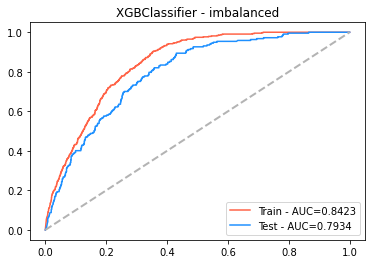

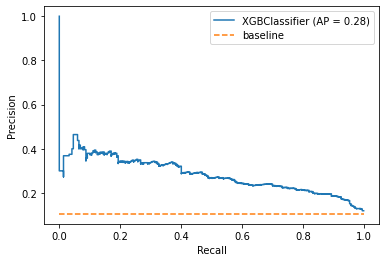

In [ ]:
name = 'imbalanced'
data, targets = train_sets[name]

print('XGBoost model - Imbalanced (Weighted)')

scale_pos_weight = (len(targets) - sum(targets)) / sum(targets)
model = xgb.XGBClassifier(objective ='binary:logistic', scale_pos_weight=scale_pos_weight,
                            random_state=random_state,
                            colsample_bytree = 0.65,
                            learning_rate = 0.03,
                            max_depth = 3,
                            reg_alpha=21,
                            reg_lambda=12,
                            gamma=1,
                            n_estimators = 500,
                            eval_metric='auc')
model = train_xgboost(model, data, targets)

y_pred_train =  model.predict(data)
report_train = classification_report(targets, y_pred_train)
print('training set')
print(report_train) 

y_pred_test = model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)
print('test set')
print(report_test) 

plot_xgboost_roc_curve(model, data, targets)
plot_pr_curve(model, X_test, y_test)

### Undersampled

XGBoost model - Oversampled
[0]	validation_0-auc:0.730492
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.746602
[2]	validation_0-auc:0.746602
[3]	validation_0-auc:0.748926
[4]	validation_0-auc:0.751584
[5]	validation_0-auc:0.751263
[6]	validation_0-auc:0.763398
[7]	validation_0-auc:0.76129
[8]	validation_0-auc:0.763048
[9]	validation_0-auc:0.764996
[10]	validation_0-auc:0.764284
[11]	validation_0-auc:0.763849
[12]	validation_0-auc:0.763229
[13]	validation_0-auc:0.763524
[14]	validation_0-auc:0.76372
[15]	validation_0-auc:0.763764
[16]	validation_0-auc:0.763342
[17]	validation_0-auc:0.763758
[18]	validation_0-auc:0.763368
[19]	validation_0-auc:0.763844
[20]	validation_0-auc:0.763413
[21]	validation_0-auc:0.763919
[22]	validation_0-auc:0.764203
[23]	validation_0-auc:0.763632
[24]	validation_0-auc:0.763328
[25]	validation_0-auc:0.762992
[26]	validation_0-auc:0.762942
[27]	validation_0-auc:0.762999
[28]	validation_0-auc:0.76321
[29]	validation_0-auc:

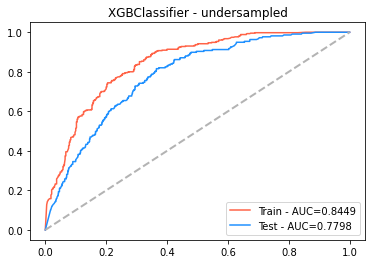

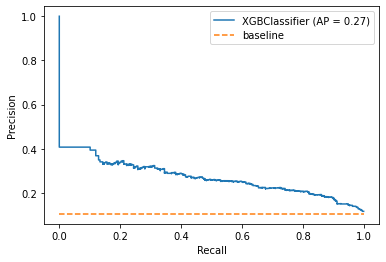

In [ ]:
name = 'undersampled'
data, targets = train_sets[name]

print('XGBoost model - Oversampled')
model = init_xgboost_model()
model = train_xgboost(model, data, targets)

y_pred_train =  model.predict(data)
report_train = classification_report(targets, y_pred_train)
print('training set')
print(report_train) 

y_pred_test = model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)
print('test set')
print(report_test) 

plot_xgboost_roc_curve(model, data, targets)
plot_pr_curve(model, X_test, y_test)

### SMOTE

XGBoost model - SMOTE
[0]	validation_0-auc:0.758038
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.76687
[2]	validation_0-auc:0.775892
[3]	validation_0-auc:0.774732
[4]	validation_0-auc:0.77695
[5]	validation_0-auc:0.7786
[6]	validation_0-auc:0.776596
[7]	validation_0-auc:0.775792
[8]	validation_0-auc:0.778933
[9]	validation_0-auc:0.780844
[10]	validation_0-auc:0.780535
[11]	validation_0-auc:0.780019
[12]	validation_0-auc:0.7798
[13]	validation_0-auc:0.779207
[14]	validation_0-auc:0.780449
[15]	validation_0-auc:0.780037
[16]	validation_0-auc:0.77949
[17]	validation_0-auc:0.779584
[18]	validation_0-auc:0.779647
[19]	validation_0-auc:0.779648
[20]	validation_0-auc:0.779755
[21]	validation_0-auc:0.779664
[22]	validation_0-auc:0.779561
[23]	validation_0-auc:0.779491
[24]	validation_0-auc:0.778994
[25]	validation_0-auc:0.7794
[26]	validation_0-auc:0.779472
[27]	validation_0-auc:0.779917
[28]	validation_0-auc:0.77988
[29]	validation_0-auc:0.78019
[30]	

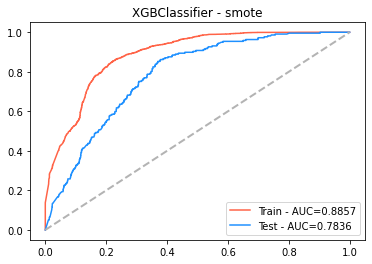

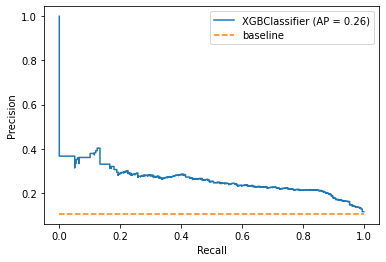

In [ ]:
name = 'smote'
data, targets = train_sets[name]

print('XGBoost model - SMOTE')
model = init_xgboost_model()
model = train_xgboost(model, data, targets)

y_pred_train =  model.predict(data)
report_train = classification_report(targets, y_pred_train)
print('training set')
print(report_train) 

y_pred_test = model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)
print('test set')
print(report_test) 

plot_xgboost_roc_curve(model, data, targets)
plot_pr_curve(model, X_test, y_test)

### SMOTE + ENN

XGBoost model - SMOTE-ENN
[0]	validation_0-auc:0.753143
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.756395
[2]	validation_0-auc:0.761685
[3]	validation_0-auc:0.770779
[4]	validation_0-auc:0.76775
[5]	validation_0-auc:0.767077
[6]	validation_0-auc:0.770011
[7]	validation_0-auc:0.770332
[8]	validation_0-auc:0.772664
[9]	validation_0-auc:0.772907
[10]	validation_0-auc:0.773812
[11]	validation_0-auc:0.773906
[12]	validation_0-auc:0.77328
[13]	validation_0-auc:0.772995
[14]	validation_0-auc:0.773102
[15]	validation_0-auc:0.773225
[16]	validation_0-auc:0.774307
[17]	validation_0-auc:0.774311
[18]	validation_0-auc:0.774241
[19]	validation_0-auc:0.77479
[20]	validation_0-auc:0.775409
[21]	validation_0-auc:0.775491
[22]	validation_0-auc:0.775334
[23]	validation_0-auc:0.774797
[24]	validation_0-auc:0.775273
[25]	validation_0-auc:0.775341
[26]	validation_0-auc:0.776382
[27]	validation_0-auc:0.776144
[28]	validation_0-auc:0.776344
[29]	validation_0-auc:0.

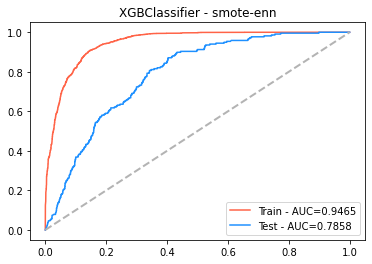

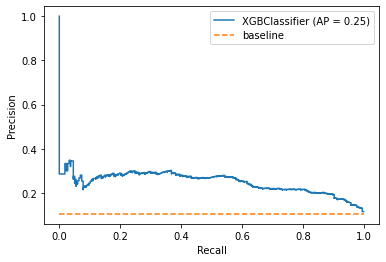

In [ ]:
name = 'smote-enn'
data, targets = train_sets[name]

print('XGBoost model - SMOTE-ENN')
model = init_xgboost_model()
model = train_xgboost(model, data, targets)

y_pred_train =  model.predict(data)
report_train = classification_report(targets, y_pred_train)
print('training set')
print(report_train) 

y_pred_test = model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)
print('test set')
print(report_test) 

plot_xgboost_roc_curve(model, data, targets)
plot_pr_curve(model, X_test, y_test)

### SMOTE + Tomek Links

XGBoost model - SMOTE-TOMEK
[0]	validation_0-auc:0.758038
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.76687
[2]	validation_0-auc:0.775892
[3]	validation_0-auc:0.774206
[4]	validation_0-auc:0.775887
[5]	validation_0-auc:0.774215
[6]	validation_0-auc:0.772605
[7]	validation_0-auc:0.773614
[8]	validation_0-auc:0.777556
[9]	validation_0-auc:0.779394
[10]	validation_0-auc:0.779984
[11]	validation_0-auc:0.779467
[12]	validation_0-auc:0.77946
[13]	validation_0-auc:0.778067
[14]	validation_0-auc:0.780345
[15]	validation_0-auc:0.780799
[16]	validation_0-auc:0.78049
[17]	validation_0-auc:0.780323
[18]	validation_0-auc:0.780517
[19]	validation_0-auc:0.780333
[20]	validation_0-auc:0.780201
[21]	validation_0-auc:0.780358
[22]	validation_0-auc:0.780014
[23]	validation_0-auc:0.779341
[24]	validation_0-auc:0.779237
[25]	validation_0-auc:0.779508
[26]	validation_0-auc:0.779498
[27]	validation_0-auc:0.780203
[28]	validation_0-auc:0.780174
[29]	validation_0-auc:

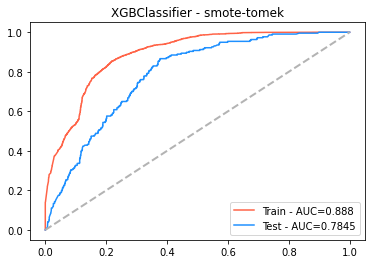

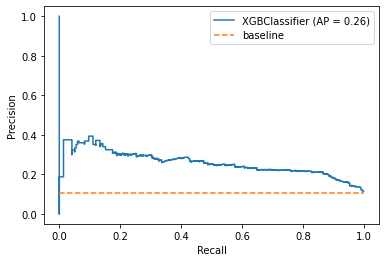

In [ ]:
name = 'smote-tomek'
data, targets = train_sets[name]

print('XGBoost model - SMOTE-TOMEK')
model = init_xgboost_model()
model = train_xgboost(model, data, targets)

y_pred_train =  model.predict(data)
report_train = classification_report(targets, y_pred_train)
print('training set')
print(report_train) 

y_pred_test = model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)
print('test set')
print(report_test) 

plot_xgboost_roc_curve(model, data, targets)
plot_pr_curve(model, X_test, y_test)

### Oversampled (Highest Test AUC)

XGBoost model - Oversampled
[0]	validation_0-auc:0.777073
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.780646
[2]	validation_0-auc:0.781535
[3]	validation_0-auc:0.782932
[4]	validation_0-auc:0.783415
[5]	validation_0-auc:0.781441
[6]	validation_0-auc:0.786803
[7]	validation_0-auc:0.786953
[8]	validation_0-auc:0.787951
[9]	validation_0-auc:0.786458
[10]	validation_0-auc:0.786354
[11]	validation_0-auc:0.786436
[12]	validation_0-auc:0.786183
[13]	validation_0-auc:0.785995
[14]	validation_0-auc:0.786107
[15]	validation_0-auc:0.785816
[16]	validation_0-auc:0.786873
[17]	validation_0-auc:0.786863
[18]	validation_0-auc:0.787144
[19]	validation_0-auc:0.786513
[20]	validation_0-auc:0.786852
[21]	validation_0-auc:0.78678
[22]	validation_0-auc:0.786449
[23]	validation_0-auc:0.786102
[24]	validation_0-auc:0.785531
[25]	validation_0-auc:0.78577
[26]	validation_0-auc:0.785892
[27]	validation_0-auc:0.788354
[28]	validation_0-auc:0.788695
[29]	validation_0-auc

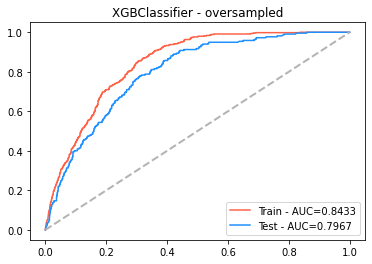

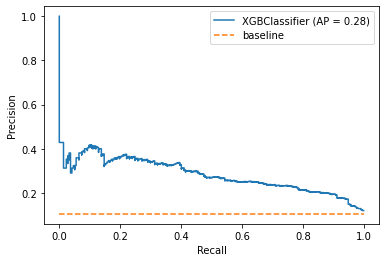

In [ ]:
name = 'oversampled'
data, targets = train_sets[name]

print('XGBoost model - Oversampled')
model = init_xgboost_model()
model = train_xgboost(model, data, targets)

y_pred_train =  model.predict(data)
report_train = classification_report(targets, y_pred_train)
print('training set')
print(report_train) 

y_pred_test = model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)
print('test set')
print(report_test) 

plot_xgboost_roc_curve(model, data, targets)
plot_pr_curve(model, X_test, y_test)

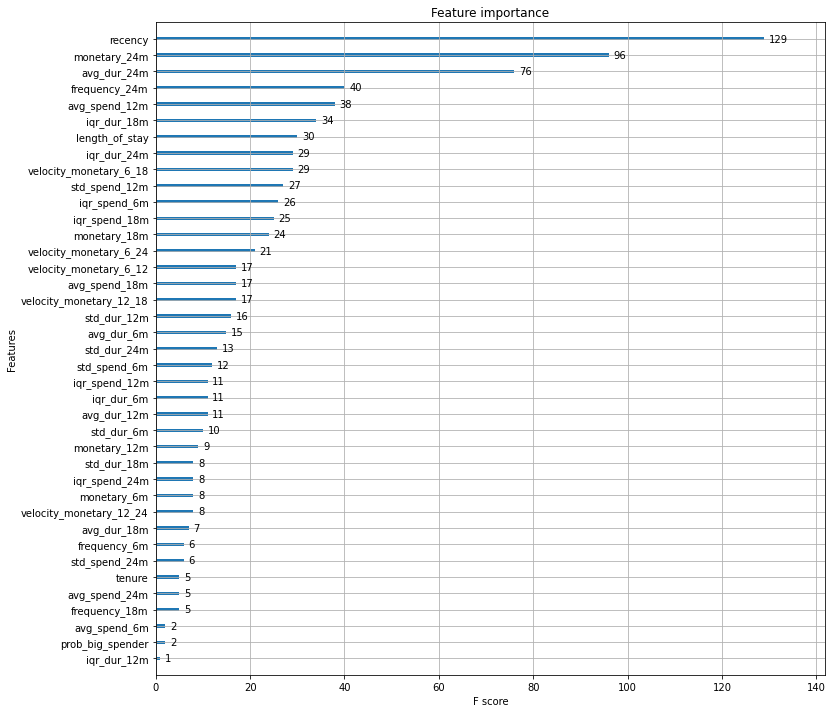

In [ ]:
plt.figure(figsize=(12,12))
xgb.plot_importance(model, ax=plt.gca());

## Selected Models with Tuned Parameters

### Oversampled + XGBoost

XGBoost model - Oversampled
[0]	validation_0-auc:0.777073
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.781312
[2]	validation_0-auc:0.781006
[3]	validation_0-auc:0.781084
[4]	validation_0-auc:0.780325
[5]	validation_0-auc:0.779093
[6]	validation_0-auc:0.780701
[7]	validation_0-auc:0.781153
[8]	validation_0-auc:0.783047
[9]	validation_0-auc:0.785363
[10]	validation_0-auc:0.78577
[11]	validation_0-auc:0.785512
[12]	validation_0-auc:0.785332
[13]	validation_0-auc:0.784995
[14]	validation_0-auc:0.784763
[15]	validation_0-auc:0.784357
[16]	validation_0-auc:0.784387
[17]	validation_0-auc:0.784058
[18]	validation_0-auc:0.784229
[19]	validation_0-auc:0.78478
[20]	validation_0-auc:0.784543
[21]	validation_0-auc:0.784477
[22]	validation_0-auc:0.78378
[23]	validation_0-auc:0.783874
[24]	validation_0-auc:0.783809
[25]	validation_0-auc:0.787287
[26]	validation_0-auc:0.788832
[27]	validation_0-auc:0.788203
[28]	validation_0-auc:0.788422
[29]	validation_0-auc:

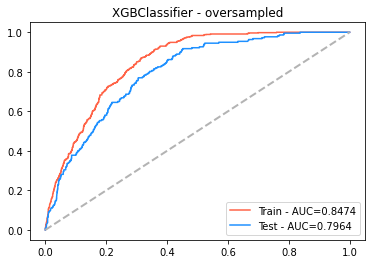

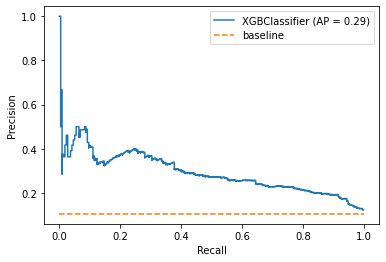

In [ ]:
name = 'oversampled'
data, targets = train_sets[name]

print('XGBoost model - Oversampled')
# {'n_estimators': 737, 'max_depth': 3, 'reg_alpha': 10, 'reg_lambda': 8, 'min_child_weight': 1, 'gamma': 4, 'learning_rate': 0.01703568120656202, 'colsample_bytree': 0.79}
scale_pos_weight = (len(targets) - sum(targets)) / sum(targets)
model = xgb.XGBClassifier(objective ='binary:logistic', scale_pos_weight=scale_pos_weight,
                            random_state=random_state,
                            colsample_bytree = 0.79,
                            learning_rate = 0.01703568120656202,
                            max_depth = 3,
                            reg_alpha=10,
                            reg_lambda=8,
                            gamma=4,
                            n_estimators = 737,
                            min_child_weight = 1,
                            eval_metric='auc')
model = train_xgboost(model, data, targets)

y_pred_train =  model.predict(data)
report_train = classification_report(targets, y_pred_train)
print('training set')
print(report_train) 

y_pred_test = model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)
print('test set')
print(report_test) 

plot_xgboost_roc_curve(model, data, targets)
plot_pr_curve(model, X_test, y_test)

### No resampling + XGBoost with Weight

[0]	validation_0-auc:0.756233
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.76553
[2]	validation_0-auc:0.773129
[3]	validation_0-auc:0.786572
[4]	validation_0-auc:0.787663
[5]	validation_0-auc:0.786428
[6]	validation_0-auc:0.790128
[7]	validation_0-auc:0.791202
[8]	validation_0-auc:0.794324
[9]	validation_0-auc:0.793593
[10]	validation_0-auc:0.794467
[11]	validation_0-auc:0.795639
[12]	validation_0-auc:0.796189
training set
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      4388
           1       0.19      0.86      0.32       430

    accuracy                           0.67      4818
   macro avg       0.59      0.75      0.55      4818
weighted avg       0.91      0.67      0.74      4818

test set
              precision    recall  f1-score   support

           0       0.96      0.66      0.78      1849
           1       0.21      0.80      0.34       217

    accuracy                   

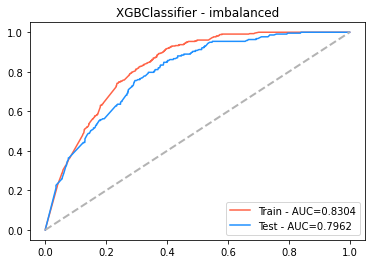

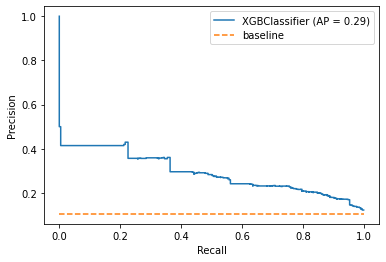

In [ ]:
name = 'imbalanced'
data, targets = train_sets[name]

# {'n_estimators': 13, 'max_depth': 2, 'reg_alpha': 3, 'reg_lambda': 3, 'min_child_weight': 4, 'gamma': 4, 'learning_rate': 0.2337084725058377, 'colsample_bytree': 0.54}
scale_pos_weight = (len(targets) - sum(targets)) / sum(targets)
model = xgb.XGBClassifier(objective ='binary:logistic', scale_pos_weight=scale_pos_weight,
                            random_state=random_state,
                            colsample_bytree = 0.54,
                            learning_rate = 0.2337084725058377,
                            max_depth = 2,
                            reg_alpha=3,
                            reg_lambda=3,
                            gamma=4,
                            n_estimators = 13,
                            min_child_weight = 4,
                            eval_metric='auc')
model = train_xgboost(model, data, targets)

y_pred_train =  model.predict(data)
report_train = classification_report(targets, y_pred_train)
print('training set')
print(report_train) 

y_pred_test = model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)
print('test set')
print(report_test) 

plot_xgboost_roc_curve(model, data, targets)
plot_pr_curve(model, X_test, y_test)

## SHAP Tree Explainer

In [ ]:
!pip install shap

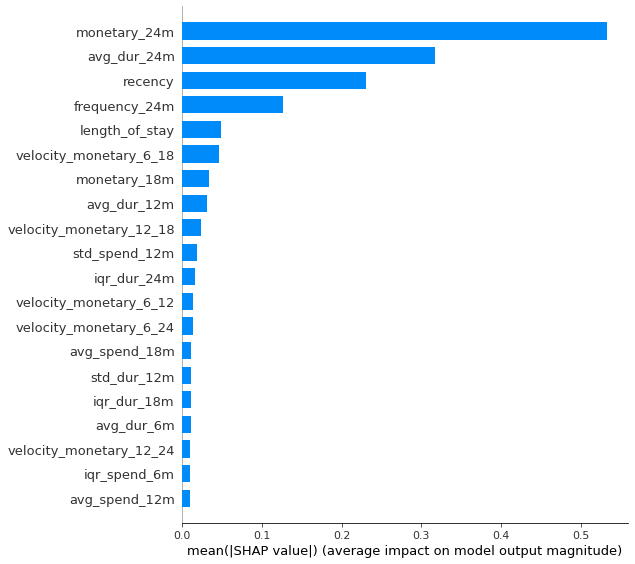

In [ ]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(data)
shap.summary_plot(shap_values, data, plot_type="bar")

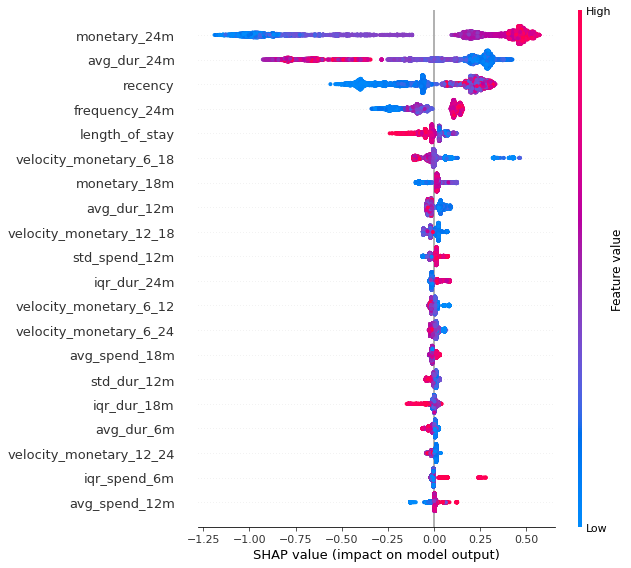

In [ ]:
shap.summary_plot(shap_values, data)

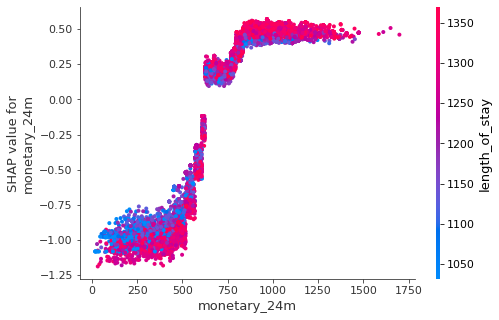

In [ ]:
shap.dependence_plot('monetary_24m', shap_values, data)

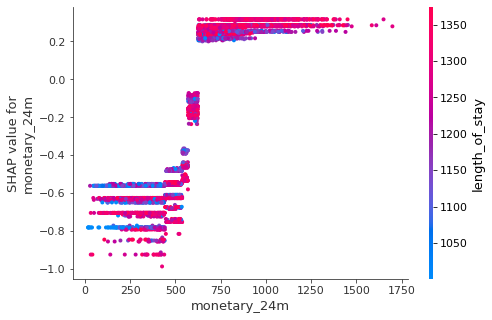

In [ ]:
shap.dependence_plot('monetary_24m', shap_values, data)

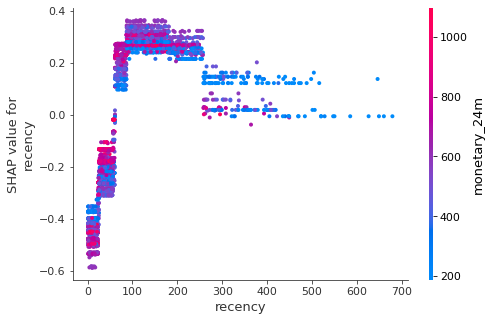

In [ ]:
shap.dependence_plot('recency', shap_values, data)

# Future improvements

- Proper implementation by using train-valid-test and cross validation  
an expert suggests that this seems overfitting to the test-set
- SHAP Tree Explainer interpretation
- Hyperparameter Tuning, try Optuna
